In [118]:
# %pip install hf_xet
# %pip install torch
# %pip install readability-lxml
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install transformers
# %pip install nltk
# %pip install beautifulsoup4
# %pip install requests
# %pip install spacy
# !python -m spacy download es_core_news_sm
# !python -m spacy download en_core_web_sm
# !python -m spacy download ca_core_news_sm
# %pip install WordCloud
# %pip install --upgrade transformers tokenizers sentencepiece
# %pip install sentencepiece
# %pip install trafilatura
# %pip install matplotlib
# %pip install scikit-learn
# %pip install datasets

In [119]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
from transformers.pipelines import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
import torch
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import trafilatura
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset



# # Descargar recursos necesarios de NLTK
nltk.download('punkt_tab')
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

def generate_summary_a(article_text):
    
    # BART puede manejar hasta 1024 tokens (no caracteres)
    inputs = tokenizer(
        article_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024  # Ahora usa tokens, no caracteres
    )

    summary_ids = model.generate(
        inputs["input_ids"],  # Corregido: era "input_id" sin 's'
        max_length=150,  # Resumen más largo para capturar más información
        min_length=60,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name, model_max_length=512)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def generate_summary_b(article_text):
    

    # Prefix obligatori per a T5
    input_text = f"summarize: {article_text.strip()}"
    
    # Tokenització i codificació
    inputs = tokenizer(
        input_text, 
        return_tensors="pt", 
        max_length=512, 
        truncation=True
    )

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            num_beams=4,
            max_length=180,  # Resumen más largo
            min_length=50,
            output_scores=True,
            return_dict_in_generate=True
        )

    # Decodificació
    resumen = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    return resumen
    
    logits = torch.stack(outputs.scores, dim=1) 
    probs = torch.softmax(logits, dim=-1)


Loading weights: 100%|██████████| 257/257 [00:00<00:00, 1168.90it/s, Materializing param=shared.weight]                                                      


In [121]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def classifier_a(data):
    from transformers import pipeline

    # Crear pipeline i definir model
    # Important si el text es en anglés, posar els topics també en anglés

    # Definició dels topics
    # Definició dels temes que pot tenir l'article
    # possible_labels = ["política", "deportes", "economía", "ciencia", "noticias","tecnología", "salud", "cultura", "guerra", "internacional"]
    
    possible_labels = [
        "professional sports and athletes",
        "government and political institutions",
        "international political relations",
        "economic and financial news",
        "science and research",
        "technology and innovation",
        "health and medicine",
        "arts and culture",
        "entertainment and celebrities"
    ]

    article_text = data[:800]

    result = classifier(
        article_text,
        candidate_labels=possible_labels,
        hypothesis_template="This article is mainly about {}.",
        device=0
    )

    print("Topic més probable:", result['labels'][0])
    print("Scores:", list(zip(result['labels'], result['scores'])))
    return result



dataset = load_dataset("ag_news")

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

label_map = {
    0: "international",   # World
    1: "sports",
    2: "economy",
    3: "science_tech"
}

train_labels = [label_map[l] for l in train_labels]

nb_model = make_pipeline(
    TfidfVectorizer(
        max_features=40000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=3
    ),
    MultinomialNB(alpha=0.2)
)

nb_model.fit(train_texts, train_labels)


def classifier_b(tokens):
    text = " ".join(tokens)

    probas = nb_model.predict_proba([text])[0]
    idx = probas.argmax()

    return {
        "labels": [nb_model.classes_[idx]],
        "scores": [float(probas[idx])]
    }



Loading weights: 100%|██████████| 515/515 [00:00<00:00, 1098.40it/s, Materializing param=model.shared.weight]                                   


In [122]:
def show_wordcloud(txt):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(txt)

    # Mostrar el núvol de paraules
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Ocultar ejes
    plt.show()

In [123]:
def title_article_preprocessing_a(clean_text):

    # 1. Toeknize del texte
    # tokens = word_tokenize(clean_text, language='spanish')
    tokens = word_tokenize(clean_text, language='english')
    
    # 2. Normalitzar a minúscules i eliminar puntuació
    tokens = [t.lower() for t in tokens if t.isalpha()]  # solo palabras
    
    # 3. Eliminar stopweords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    # print(tokens[:50])

    return tokens


def title_article_preprocessing_b(clean_text):
    # Carrega del model
    
    nlp = spacy.load("en_core_web_sm")
    
    # Processament
    doc = nlp(clean_text)
    
    # 1. Neteja bàsica amb spaCy (Eliminar stop words i puntuació)
    tokens_limpios = [
    token.text.strip() 
    for token in doc 
    if not token.is_stop and not token.is_punct and not token.is_space
    ]

    # Per si de cas queda algun string buit després del strip()
    tokens_limpios = [t for t in tokens_limpios if t]

    print(f"Primers 20 tokens nets (Opció B): {tokens_limpios[:20]}")
    show_wordcloud(' '.join(tokens_limpios))

    return tokens_limpios
    train_model(tokens_limpios)

In [124]:
import requests
from bs4 import BeautifulSoup
from readability import Document
from lxml import html

url = "https://link.springer.com/article/10.1186/s12915-020-00925-x"



def scrape_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # 1. Intentar <article>
    article = soup.find("article")
    if article:
        text = article.get_text(separator="\n")
    else:
        # 2. Intentar <main>
        main = soup.find("main")
        if main:
            text = main.get_text(separator="\n")
        else:
            # 3. Fallback: todos los <p>, unir el bloque más largo
            paragraphs = soup.find_all("p")
            blocks = []
            current_block = []
            for p in paragraphs:
                current_block.append(p.get_text())
                # Separar bloques grandes por lógica simple
                if len(current_block) > 3:  
                    blocks.append("\n".join(current_block))
                    current_block = []
            if current_block:
                blocks.append("\n".join(current_block))
            # Elegir el bloque más largo (probable artículo)
            text = max(blocks, key=len) if blocks else ""
    
    # Limpiar líneas vacías
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    data = "\n".join(lines)

    return data


# def scrape_text_refined(url):
#     response = requests.get(url)
#     response.raise_for_status()

#     tree = html.fromstring(response.content)

#     # Buscar el contenedor principal del artículo (para Springer suele ser c-article-body)
#     article_divs = tree.xpath('//div[contains(@class,"c-article-body")]')
    
#     if article_divs:
#         paragraphs = article_divs[0].xpath('.//p//text()')
#         data = "\n".join([p.strip() for p in paragraphs if p.strip()])
#     else:
#         # Fallback: todos los <p> de la página
#         paragraphs = tree.xpath('//p//text()')
#         data = "\n".join([p.strip() for p in paragraphs if p.strip()])


#     return data

def scrape_text_advanced(url):
    try:
        # Descarregar la pàgina web amb un User-Agent vàlid
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=15)
        
        # Forcem que la resposta sigui interpretada com a UTF-8
        response.encoding = 'utf-8' 
        
        if response.status_code == 200:
            # 2. Li passem el contingut ja descarregat a trafilatura per només obtenir el cos del text, l'article.
            clean_text = trafilatura.extract(response.text, include_comments=False)
            
            if clean_text:
                print(clean_text[:1000])  # Mostrar només els primers 1000 caràcters
                return clean_text
        
        return None

    except Exception as e:
        print(f"Error en la descarga: {e}")
        return None


    


In [125]:
execution_results = {}

def execution_1(url):
    data = scrape_text(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 1)
    print(f"Resum de l'article: {resume}")


def execution_2(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 2)
    print(f"Resum de l'article: {resume}")


def execution_3(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_b(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 3)
    print(f"Resum de l'article: {resume}")


def execution_4(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_b(tokens)
    resume = generate_summary_a(data)

    save_results(results, 4)
    print(f"Resum de l'article: {resume}")


def execution_5(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_b(data)

    save_results(results, 5)
    print(f"Resum de l'article: {resume}")


def save_results(results, num):
        execution_results[f"execution_{num}"] = {
        "topic": results['labels'][0],
        "score": results['scores'][0]
    }
    


############# Execution 1: URLhttps://edition.cnn.com/2026/02/04/sport/simon-billy-speed-skier-world-record-winter-olympics
Topic més probable: professional sports and athletes
Scores: [('professional sports and athletes', 0.24771742522716522), ('technology and innovation', 0.12960824370384216), ('arts and culture', 0.1266019344329834), ('entertainment and celebrities', 0.10949356108903885), ('health and medicine', 0.09750071913003922), ('science and research', 0.08932096511125565), ('international political relations', 0.07275985181331635), ('government and political institutions', 0.06415408849716187), ('economic and financial news', 0.0628432035446167)]
Resum de l'article: Simon Billy broke the world record in 2023 with a speed of 255.500 km/h (158.760 mph) on the slopes in Vars, France . Billy never watches speed skiing live, worried it might scare him off from pushing his own limits . “It’s just crazy. It’s about freedom, just pushing the limits,” he says .
############# Execution

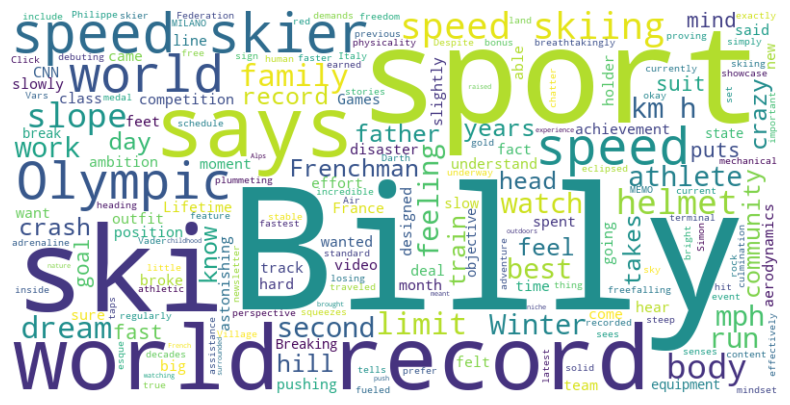

Topic més probable: professional sports and athletes
Scores: [('professional sports and athletes', 0.2661783993244171), ('arts and culture', 0.14503666758537292), ('technology and innovation', 0.10345003753900528), ('health and medicine', 0.08805559575557709), ('entertainment and celebrities', 0.08568636327981949), ('science and research', 0.08432482928037643), ('international political relations', 0.08085279911756516), ('economic and financial news', 0.07809541374444962), ('government and political institutions', 0.0683198794722557)]
Resum de l'article: the world’s fastest skier – 255.500 km/h (158.760 mph) – on the slopes in Vars, France . Billy never watches speed skiing live, worried it might scare him off from pushing his own limits . “I don’t see anything either,” he says. “It’s like a drug for us,” he says .
############# Execution 4: URLhttps://edition.cnn.com/2026/02/04/sport/simon-billy-speed-skier-world-record-winter-olympics
When he squeezes into his bright red ski suit and

In [126]:
def main():

    # urls = ["https://link.springer.com/article/10.1186/s12915-020-00925-x", 
            # "https://english.elpais.com/international/2026-02-04/palestinians-who-fled-horror-encounter-israeli-obstacles-in-attempt-to-return-to-gaza.html",
            # "https://www.bbc.com/sport/articles/c205r73r0z3o",
            # "https://edition.cnn.com/2026/02/05/business/europe-economic-independence-united-states-intl",
            # "https://english.elpais.com/science-tech/2026-02-04/discovery-of-brain-network-that-links-body-and-mind-could-open-the-door-to-better-parkinsons-treatments.html"]
    urls = ["https://edition.cnn.com/2026/02/04/sport/simon-billy-speed-skier-world-record-winter-olympics"]
    for url in urls:
        print(f"############# Execution 1: URL{url}")
        execution_1(url)

        print(f"############# Execution 2: URL{url}")
        execution_2(url)

        print(f"############# Execution 3: URL{url}")
        execution_3(url)

        print(f"############# Execution 4: URL{url}")
        execution_4(url)
        
        print(f"############# Execution 5: URL{url}")
        execution_5(url)

    print("Execution Results Summary:")
    for key, value in execution_results.items():
        print(f"{key}: Topic - {value['topic']}, Score - {value['score']}")



main()